## Price prediction using Brownian motion with drift

#### Some imports

In [1]:
import numpy as np  
import pandas as pd  
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
from tqdm.notebook import tqdm
%matplotlib inline
#use %matplotlib notebook for interactive

#### We're choosing the stock called SPY. End-of-day prices are taken starting from 2007 and put into a series

In [2]:
ticker = 'SPY' 
data_series = pd.Series(dtype='float64')
data_series = wb.DataReader(ticker, data_source='yahoo', start='2007-1-1')['Adj Close']

In [3]:
def optimize_drift(past_prices, test_size, simulations=10, resolution=2, scale=1, chop=0):
    if chop == 0:
        test_set = past_prices[-1*test_size:]
        past_prices = past_prices[0:len(past_prices)-test_size]
    if chop != 0:
        test_set = past_prices[-1*test_size-chop:-1*chop]
        past_prices = past_prices[0:len(past_prices)-test_size-chop]
    log_ret = np.log(1 + past_prices.pct_change())
    sample_mu = log_ret.mean()
    sample_var = log_ret.var()
    h_results = np.zeros((10**(resolution+1)//scale, 2))
    first = past_prices[-1]
    for h in range(len(h_results)//-2,len(h_results)//2,1):
        h_results[h,0] = h/(10**(resolution-2))
        h_results[h,1] = simulation_results(h/(10**(resolution-2)), test_size, sample_mu, sample_var, simulations, first, test_set)
    h_results = h_results[1:]
    return h_results

In [4]:
def simulation_results(h, test_size, sample_mu, sample_var, simulations, first, test_set):
    h_drift = sample_mu - (h * sample_var)
    sample_stdev = np.sqrt(sample_var)
    h_returns = np.exp(h_drift + sample_stdev * norm.ppf(np.random.rand(test_size, simulations)))
    h_prices = np.zeros_like(h_returns)
    h_prices[0] = first
    for t in range(1, test_size):
        h_prices[t] = h_prices[t - 1] * h_returns[t]
    average = sum(h_prices[-1])/len(h_prices[-1])
    losses = abs(test_set[-1] - average)
    return losses

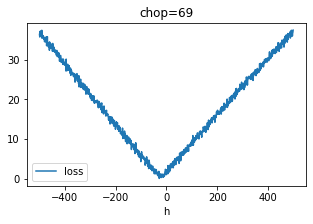

In [8]:
testing_optimization = optimize_drift(data_series, test_size=2, simulations=100, resolution=2, scale=1, chop=3)
t_o_df = pd.DataFrame(testing_optimization, columns = ['h','loss']).sort_values(by=['h'])
t_o_df.plot(x='h', y='loss', figsize=(5, 3));
plt.title('chop=69')
plt.show()

In [ ]:
for i in range(3750):
    testing_optimization = optimize_drift(data_series, test_size=2, simulations=100, resolution=2, scale=1, chop=i)
    t_o_df = pd.DataFrame(testing_optimization, columns = ['h','loss']).sort_values(by=['h'])
    t_o_df.plot(x='h', y='loss', figsize=(5, 3));
    plt.title('chop='+str(i))
    plt.show()

In [368]:
data_series

Date
2007-01-03     41.589966
2007-01-04     41.274235
2007-01-05     40.919800
2007-01-08     41.010010
2007-01-09     40.906910
                 ...    
2021-12-01    146.399994
2021-12-02    147.259995
2021-12-03    149.880005
2021-12-06    152.149994
2021-12-07    152.070007
Name: Adj Close, Length: 3760, dtype: float64

In [215]:
t_o_df

,h,loss
0,0.1,3.935829
1,0.2,4.142099
2,0.3,3.812023
3,0.4,4.700581
4,0.5,4.256517
...,...,...
999994,99999.5,144.580002
999995,99999.6,144.580002
999996,99999.7,144.580002
999997,99999.8,144.580002


In [9]:
def optimal_h_distribution(samples=100, res=1):
    h_results = []
    for _ in tqdm(range(samples)):
        sample = optimize_drift(data_series, test_size=2, simulations=100, resolution=2, scale=1, chop=3)
        sample_df = pd.DataFrame(sample)
        h_results.append((sample_df.index[sample_df[1] == sample_df[1].min()].tolist()[0])/(10**(res-2)))
    return h_results

In [11]:
trying_h = optimal_h_distribution()

  0%|          | 0/100 [00:00<?, ?it/s]

Optimal h is 9710.0


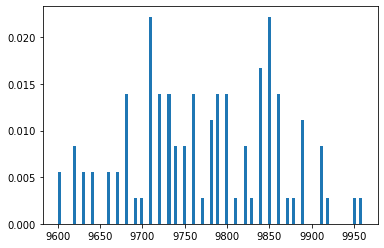

In [12]:
bins = plt.hist(trying_h, bins=100, density=True, color=None, label=None, stacked=False)
print("Optimal h is % s" % (max(set(trying_h), key = trying_h.count)))